DATASET ../IMDB-Dataset-Processed.csv


/home/olafurj/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/olafurj/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/olafurj/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

    negative       0.84      0.87      0.85      2553
    positive       0.86      0.83      0.84      2447

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000

              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      2553
    positive       0.86      0.86      0.86      2447

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

              precision    recall  f1-score   support

    negative       0.89      0.88      0.88      2553
    positive       0.87      0.89      0.88      2447

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



<Figure size 2304x1440 with 0 Axes>

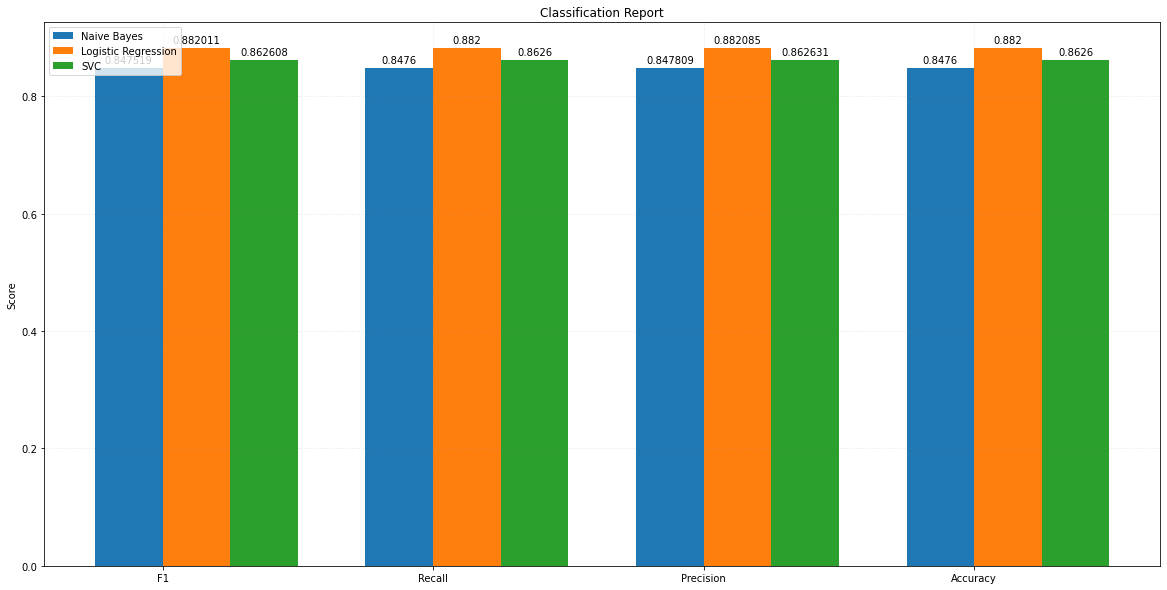

In [34]:
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
)
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):
    lines = cr.split('\n')
    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 6)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)

    plt.figure(figsize=(12,48))
    #plt.imshow(plotMat, interpolation='nearest', cmap=cmap) THIS also works but the scale is not good neither the colors for many classes(200)
    #plt.colorbar()

    plt.title(title)
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')
    
    sns.heatmap(plotMat, annot=True) 

def classify(path):
    print("DATASET %s" % path)
    data = pd.read_csv(path)
    review, sentiment = data["review"].values.astype('U'), data["sentiment"]
    x_train, x_test, y_train, y_test = train_test_split(
        review, sentiment, test_size=0.1, random_state=0
    )
    nb_pipeline = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", MultinomialNB()),
        ]
    )
    svc_pipeline = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", LinearSVC()),
        ]
    )
    lr_pipeline = Pipeline(
        [
            ("vect", TfidfVectorizer()),
            ("clf", LogisticRegression()),
        ]
    )

    nb_pipeline.fit(x_train, y_train)
    svc_pipeline.fit(x_train, y_train)
    lr_pipeline.fit(x_train, y_train)

    predict_nb = nb_pipeline.predict(x_test)
    predict_svc = svc_pipeline.predict(x_test)
    predict_lr = lr_pipeline.predict(x_test)    
        
    f1_nb = f1_score(y_test, predict_nb, average="weighted")
    recall_nb = recall_score(y_test, predict_nb, average="weighted")
    prec_nb = precision_score(y_test, predict_nb, average="weighted")
    accuracy_nb = accuracy_score(y_test, predict_nb)

    f1_svc = f1_score(y_test, predict_svc, average="weighted")
    recall_svc = recall_score(y_test, predict_svc, average="weighted")
    prec_svc = precision_score(y_test, predict_svc, average="weighted")
    accuracy_svc = accuracy_score(y_test, predict_svc)

    f1_lr = f1_score(y_test, predict_lr, average="weighted")
    recall_lr = recall_score(y_test, predict_lr, average="weighted")
    prec_lr = precision_score(y_test, predict_lr, average="weighted")
    accuracy_lr = accuracy_score(y_test, predict_lr)

    print(classification_report(y_test, predict_nb))
    print(classification_report(y_test, predict_svc))
    print(classification_report(y_test, predict_lr))

    #return { "SVC": (1,2,3,4 ), "Naive Bayes": (1,2,3,4), "Logistic Regression": (1,2,3,4) }, ["F1", "Recall", "Precision", "Accuracy"]
    return { "Naive Bayes": (f1_nb, recall_nb, prec_nb, accuracy_nb), "Logistic Regression": (f1_lr,recall_lr, prec_lr, accuracy_lr), "SVC": (f1_svc, recall_svc, prec_svc, accuracy_svc ) }, ["F1", "Recall", "Precision", "Accuracy"]

def plot_f1(f1s):
    # 
    labels, values = f1s
    
    #fig, ax = plt.subplots()
    # creating the bar plot
    #pps = plt.barh(labels, values)
    plt.figure(figsize=(32, 20))
    fig, ax = plt.subplots(figsize=(20,10)) #layout='constrained')
    
    # Add x, y gridlines
    plt.grid(color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
    # Remove x, y Ticks
    # for s in ['top', 'bottom', 'left', 'right']:
    #    ax.spines[s].set_visible(False)
    # ax.xaxis.set_ticks_position('none')
    # ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    #ax.xaxis.set_tick_params(pad = 5)
    #ax.yaxis.set_tick_params(pad = 10)
    # Show top values
    #ax.invert_yaxis()
    x = np.arange(4)
    width = 0.25
    multiplier = 0
    # Add annotation to bars
    for attr, m in labels.items():
        offset = width * multiplier
        rects = ax.bar( x + offset, m, width, label=attr)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    # for i in pps:
    #     plt.text(i.get_width()+0.2, i.get_y()+0.5,
    #             str(round((i.get_width()), 3)),
    #             fontsize = 10, fontweight ='bold',
    #             color ='grey')
    ax.set_ylabel("Score")
    ax.set_title("Classification Report")
    ax.set_xticks(x + width / 2, ("F1", "Recall", "Precision", "Accuracy"))
    plt.legend(loc='upper left')
    #plt.set_ylim(0, 250)
    
    plt.show()


#data = classify("../IMDB-Dataset-GoogleTranslate-Processed.csv")
data = classify("../IMDB-Dataset-Processed.csv")
plot_f1(data)




LogisticRegression(solver='saga')
	-11.377	hræðilegur     		12.4997	frábær         
	-9.104	slæmur         		7.6903	vel            
	-8.970	versta         		5.9034	besta          
	-8.604	leiðinlegur    		5.7820	elska          
	-7.584	lélegur        		5.2838	frábærlega     
	-6.317	illa           		4.9942	skemmtilegur   
	-5.365	vonbrigði      		4.8503	fullkominn     
	-5.256	pirrandi       		4.7077	dásamlegur     
	-5.247	bara           		4.6764	njóta          
	-5.224	líta           		4.5580	hrífandi       


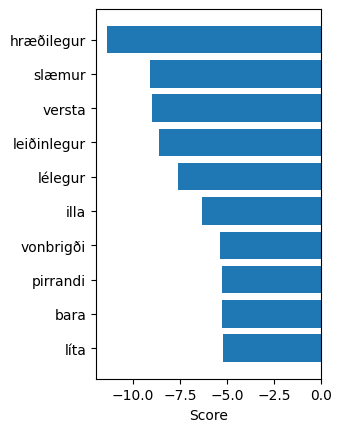

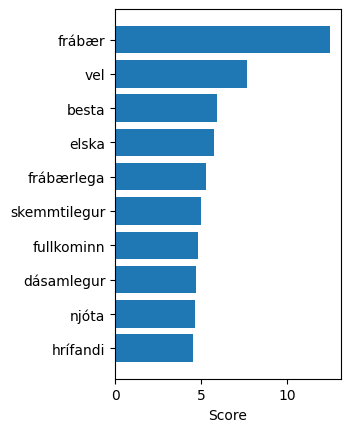

In [6]:


def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v: k for k, v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes = {}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [
            (el, index_to_word[i]) for i, el in enumerate(model.coef_[class_index])
        ]
        sorted_coeff = sorted(word_importances, key=lambda x: x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key=lambda x: x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {"tops": tops, "bottom": bottom}
    return classes

def show_most_informative_features(vectorizer, clf, n=20):
    print(clf)
    feature_names = vectorizer.get_feature_names_out()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.3f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))


#show_most_informative_features(pipeline_2[0], pipeline_2[1], n=5)
show_most_informative_features(logistic_regression_pipeline[0], logistic_regression_pipeline[1], n=10)


def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    
    top_pairs = [(a, b) for a, b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a, b) for a, b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    ax = plt.subplot(121)
    y_pos = np.arange(len(bottom_words))
    p1 = plt.barh(y_pos, bottom_scores, align="center")
    plt.yticks(y_pos, bottom_words)
    plt.xlabel("Score")
    
    plt.show()
    ax = plt.subplot(122)
    y_pos = np.arange(len(top_words))
    p2 = plt.barh(y_pos, top_scores, align="center")
    plt.yticks(y_pos, top_words)
    plt.xlabel("Score")
    plt.show()



importance = get_most_important_features(logistic_regression_pipeline[0], logistic_regression_pipeline[1], 10)
top_scores = [a[0] for a in importance[0]["tops"]]
top_words = [a[1] for a in importance[0]["tops"]]
bottom_scores = [a[0] for a in importance[0]["bottom"]]
bottom_words = [a[1] for a in importance[0]["bottom"]]


plot_important_words(
    top_scores, top_words, bottom_scores, bottom_words, "Sentiment"
)

In [ ]:
def evaluate_score(text):
    text = [text]
    s = logistic_regression_pipeline.predict(text)
    # find all features and coefficients that have the text and sum up the values
    s = sum([ i[1] for x, i in enumerate(zip(logistic_regression_pipeline[0].get_feature_names_out(), 
                                        logistic_regression_pipeline[1].coef_[0])) 
        if i[0] in text[0].split(" ") ])
    if s >= 1:
        print("(%s) Positive, score is %f" % (text[0], s))
    else:
        print("(%s) Negative, score is %f" % (text[0], s))


evaluate_score("hræðilegur frábær")
evaluate_score("slæmur vel besta")
evaluate_score("lélegur vel")